# Bibliotecas

In [2]:
# Manipulação e estruturação
import pandas as pd
import numpy as np

# Modelagem
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE, SelectFromModel

# Avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Pré-processamento
from sklearn.preprocessing import StandardScaler

# Visualização
import matplotlib.pyplot as plt



# Treinamento 2010 - 2021

## Preparação dos Dados

In [3]:
df = pd.read_csv("../../camada_ouro/Join_dataframes_new_end.csv", parse_dates=["Date"])
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [4]:
# Limpeza de colunas com %
df['Value_IPCA'] = df['Value_IPCA'].str.replace('%', '').astype(float) / 100

display(df)

,Date,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Índice_Ibovespa,Year-Month,Value_IPCA,Inflac_IPCA,IPCA_Acumulado
0,2010-01-29,33.935703,16106857.97,18.284323,72.89,335.27,65401.77,2010-1,0.0075,0.75,4.312028
1,2010-02-26,31.895180,17804380.32,17.368318,79.66,319.04,66503.27,2010-2,0.0078,0.78,4.592325
2,2010-03-31,37.114391,16551869.40,20.546054,83.76,371.96,70371.54,2010-3,0.0052,0.52,4.831572
3,2010-04-30,30.474053,15688008.79,17.322677,86.15,392.14,67529.73,2010-4,0.0057,0.57,5.166363
4,2010-05-28,29.272740,20301487.26,15.804308,73.97,420.67,61946.99,2010-5,0.0043,0.43,5.260561
...,...,...,...,...,...,...,...,...,...,...,...
175,2024-08-30,36.640116,84437156.59,7.343150,72.65,210.33,136004.01,2024-8,-0.0002,-0.02,4.498245
176,2024-09-30,36.946330,21146409.59,7.156535,67.77,189.29,131816.44,2024-9,0.0044,0.44,4.237599
177,2024-10-31,34.453725,25596765.78,6.663648,68.81,109.20,129713.33,2024-10,0.0056,0.56,4.424740
178,2024-11-29,38.699903,44011586.42,7.111861,67.72,106.39,125667.83,2024-11,0.0039,0.39,4.758099


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               180 non-null    datetime64[ns]
 1   Close_Real_EYAC2   180 non-null    float64       
 2   Volume_EYAC2       180 non-null    float64       
 3   Close_Dolar_EYAC2  180 non-null    float64       
 4   Price_Dolar_Petro  180 non-null    float64       
 5   Volume_Petro       180 non-null    float64       
 6   Índice_Ibovespa    180 non-null    float64       
 7   Year-Month         180 non-null    object        
 8   Value_IPCA         180 non-null    float64       
 9   Inflac_IPCA        180 non-null    float64       
 10  IPCA_Acumulado     180 non-null    float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 15.6+ KB


## Alvo

In [6]:
df['target'] = df['Close_Real_EYAC2'].shift(-1)  # prever o preço da ação no próximo dia

## Feature Engineering 

### Retornos percentuais diários

In [7]:
df['retorno_acao'] = df['Close_Real_EYAC2'].pct_change()
df['retorno_petro'] = df['Price_Dolar_Petro'].pct_change()

df.tail()


,Date,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Índice_Ibovespa,Year-Month,Value_IPCA,Inflac_IPCA,IPCA_Acumulado,target,retorno_acao,retorno_petro
175,2024-08-30,36.640116,84437156.59,7.343150,72.65,210.33,136004.01,2024-8,-0.0002,-0.02,4.498245,36.946330,-0.010822,-0.054529
176,2024-09-30,36.946330,21146409.59,7.156535,67.77,189.29,131816.44,2024-9,0.0044,0.44,4.237599,34.453725,0.008357,-0.067171
177,2024-10-31,34.453725,25596765.78,6.663648,68.81,109.20,129713.33,2024-10,0.0056,0.56,4.424740,38.699903,-0.067466,0.015346
178,2024-11-29,38.699903,44011586.42,7.111861,67.72,106.39,125667.83,2024-11,0.0039,0.39,4.758099,36.614223,0.123243,-0.015841
179,2024-12-30,36.614223,22355586.67,6.605965,70.53,93.10,120283.40,2024-12,0.0052,0.52,4.873011,NaN,-0.053894,0.041494


### Médias móveis

In [8]:
df['mm7_acao'] = df['Close_Real_EYAC2'].rolling(7).mean()

df.tail()

,Date,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Índice_Ibovespa,Year-Month,Value_IPCA,Inflac_IPCA,IPCA_Acumulado,target,retorno_acao,retorno_petro,mm7_acao
175,2024-08-30,36.640116,84437156.59,7.343150,72.65,210.33,136004.01,2024-8,-0.0002,-0.02,4.498245,36.946330,-0.010822,-0.054529,38.345094
176,2024-09-30,36.946330,21146409.59,7.156535,67.77,189.29,131816.44,2024-9,0.0044,0.44,4.237599,34.453725,0.008357,-0.067171,37.921896
177,2024-10-31,34.453725,25596765.78,6.663648,68.81,109.20,129713.33,2024-10,0.0056,0.56,4.424740,38.699903,-0.067466,0.015346,37.804163
178,2024-11-29,38.699903,44011586.42,7.111861,67.72,106.39,125667.83,2024-11,0.0039,0.39,4.758099,36.614223,0.123243,-0.015841,37.343262
179,2024-12-30,36.614223,22355586.67,6.605965,70.53,93.10,120283.40,2024-12,0.0052,0.52,4.873011,NaN,-0.053894,0.041494,37.164952


### Volatilidade

In [9]:
df['vol_7_acao'] = df['Close_Real_EYAC2'].rolling(7).std()
df['vol_30_acao'] = df['Close_Real_EYAC2'].rolling(30).std()

df.tail()

,Date,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Índice_Ibovespa,Year-Month,Value_IPCA,Inflac_IPCA,IPCA_Acumulado,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao
175,2024-08-30,36.640116,84437156.59,7.343150,72.65,210.33,136004.01,2024-8,-0.0002,-0.02,4.498245,36.946330,-0.010822,-0.054529,38.345094,2.291950,5.089275
176,2024-09-30,36.946330,21146409.59,7.156535,67.77,189.29,131816.44,2024-9,0.0044,0.44,4.237599,34.453725,0.008357,-0.067171,37.921896,2.227711,5.169478
177,2024-10-31,34.453725,25596765.78,6.663648,68.81,109.20,129713.33,2024-10,0.0056,0.56,4.424740,38.699903,-0.067466,0.015346,37.804163,2.405426,5.145054
178,2024-11-29,38.699903,44011586.42,7.111861,67.72,106.39,125667.83,2024-11,0.0039,0.39,4.758099,36.614223,0.123243,-0.015841,37.343262,1.685257,5.156868
179,2024-12-30,36.614223,22355586.67,6.605965,70.53,93.10,120283.40,2024-12,0.0052,0.52,4.873011,NaN,-0.053894,0.041494,37.164952,1.687206,5.036931


### Defasagens

In [10]:
df['lag1_acao'] = df['Close_Real_EYAC2'].shift(1)
df['lag60_acao'] = df['Close_Real_EYAC2'].shift(60)

df.tail()

,Date,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Índice_Ibovespa,Year-Month,Value_IPCA,Inflac_IPCA,IPCA_Acumulado,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
175,2024-08-30,36.640116,84437156.59,7.343150,72.65,210.33,136004.01,2024-8,-0.0002,-0.02,4.498245,36.946330,-0.010822,-0.054529,38.345094,2.291950,5.089275,37.040958,24.936869
176,2024-09-30,36.946330,21146409.59,7.156535,67.77,189.29,131816.44,2024-9,0.0044,0.44,4.237599,34.453725,0.008357,-0.067171,37.921896,2.227711,5.169478,36.640116,25.236485
177,2024-10-31,34.453725,25596765.78,6.663648,68.81,109.20,129713.33,2024-10,0.0056,0.56,4.424740,38.699903,-0.067466,0.015346,37.804163,2.405426,5.145054,36.946330,31.298800
178,2024-11-29,38.699903,44011586.42,7.111861,67.72,106.39,125667.83,2024-11,0.0039,0.39,4.758099,36.614223,0.123243,-0.015841,37.343262,1.685257,5.156868,34.453725,26.719566
179,2024-12-30,36.614223,22355586.67,6.605965,70.53,93.10,120283.40,2024-12,0.0052,0.52,4.873011,NaN,-0.053894,0.041494,37.164952,1.687206,5.036931,38.699903,30.690218


In [11]:
df_test = df[['Date','target','retorno_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao','lag1_acao', 'lag60_acao']]
display(df_test)

,Date,target,retorno_acao,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
0,2010-01-29,31.895180,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-02-26,37.114391,-0.060129,NaN,NaN,NaN,33.935703,NaN
2,2010-03-31,30.474053,0.163636,NaN,NaN,NaN,31.895180,NaN
3,2010-04-30,29.272740,-0.178915,NaN,NaN,NaN,37.114391,NaN
4,2010-05-28,26.856487,-0.039421,NaN,NaN,NaN,30.474053,NaN
...,...,...,...,...,...,...,...,...
175,2024-08-30,36.946330,-0.010822,38.345094,2.291950,5.089275,37.040958,24.936869
176,2024-09-30,34.453725,0.008357,37.921896,2.227711,5.169478,36.640116,25.236485
177,2024-10-31,38.699903,-0.067466,37.804163,2.405426,5.145054,36.946330,31.298800
178,2024-11-29,36.614223,0.123243,37.343262,1.685257,5.156868,34.453725,26.719566


## Tratamento dos dados

Essas transformações geram valores NaN no início da série, por exemplo:

pct_change() → NaN na primeira linha

rolling(7).mean() → NaN nas 6 primeiras linhas

shift(1) → NaN na primeira linha

Esses NaNs atrapalham o treino do modelo e precisam ser removidos antes de separar treino/teste ou aplicar model.fit().

In [12]:
df_nan = df.copy()

# Preencher os NaN restantes usando o valor posterior (bfill)
df_nan[['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 
          'retorno_acao', 'retorno_petro',]] = \
df_nan[['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 
          'retorno_acao', 'retorno_petro',]].fillna(method='bfill')

# Verificar se ainda há NaN após preenchimento com bfill 
nan_counts_after_filling = df_nan[['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 
          'retorno_acao', 'retorno_petro',]].isna().sum()

print("Após interpolação e bfill, contagem de NaN:", nan_counts_after_filling)

print(df_nan.head())


Após interpolação e bfill, contagem de NaN: lag1_acao        0
lag60_acao       0
mm7_acao         0
vol_7_acao       0
vol_30_acao      0
retorno_acao     0
retorno_petro    0
dtype: int64
        Date  Close_Real_EYAC2  Volume_EYAC2  Close_Dolar_EYAC2  \
0 2010-01-29         33.935703   16106857.97          18.284323   
1 2010-02-26         31.895180   17804380.32          17.368318   
2 2010-03-31         37.114391   16551869.40          20.546054   
3 2010-04-30         30.474053   15688008.79          17.322677   
4 2010-05-28         29.272740   20301487.26          15.804308   

   Price_Dolar_Petro  Volume_Petro  Índice_Ibovespa Year-Month  Value_IPCA  \
0              72.89        335.27         65401.77     2010-1      0.0075   
1              79.66        319.04         66503.27     2010-2      0.0078   
2              83.76        371.96         70371.54     2010-3      0.0052   
3              86.15        392.14         67529.73     2010-4      0.0057   
4              73

C:\Users\FM972EJ\AppData\Local\Temp\ipykernel_27728\613474823.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  'retorno_acao', 'retorno_petro',]].fillna(method='bfill')


In [13]:
df_nan.isna().sum()

Date                 0
Close_Real_EYAC2     0
Volume_EYAC2         0
Close_Dolar_EYAC2    0
Price_Dolar_Petro    0
Volume_Petro         0
Índice_Ibovespa      0
Year-Month           0
Value_IPCA           0
Inflac_IPCA          0
IPCA_Acumulado       0
target               1
retorno_acao         0
retorno_petro        0
mm7_acao             0
vol_7_acao           0
vol_30_acao          0
lag1_acao            0
lag60_acao           0
dtype: int64

In [14]:
df_model = df_nan.dropna().copy()   

df_model.tail(2)

,Date,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Índice_Ibovespa,Year-Month,Value_IPCA,Inflac_IPCA,IPCA_Acumulado,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
177,2024-10-31,34.453725,25596765.78,6.663648,68.81,109.20,129713.33,2024-10,0.0056,0.56,4.424740,38.699903,-0.067466,0.015346,37.804163,2.405426,5.145054,36.946330,31.298800
178,2024-11-29,38.699903,44011586.42,7.111861,67.72,106.39,125667.83,2024-11,0.0039,0.39,4.758099,36.614223,0.123243,-0.015841,37.343262,1.685257,5.156868,34.453725,26.719566


In [15]:
df_model.isna().sum()

Date                 0
Close_Real_EYAC2     0
Volume_EYAC2         0
Close_Dolar_EYAC2    0
Price_Dolar_Petro    0
Volume_Petro         0
Índice_Ibovespa      0
Year-Month           0
Value_IPCA           0
Inflac_IPCA          0
IPCA_Acumulado       0
target               0
retorno_acao         0
retorno_petro        0
mm7_acao             0
vol_7_acao           0
vol_30_acao          0
lag1_acao            0
lag60_acao           0
dtype: int64

In [16]:
df_test1 = df_model[['Date','target','retorno_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao','lag1_acao', 'lag60_acao']]
display(df_test1)


,Date,target,retorno_acao,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
0,2010-01-29,31.895180,-0.060129,30.900892,3.767463,4.751344,33.935703,33.935703
1,2010-02-26,37.114391,-0.060129,30.900892,3.767463,4.751344,33.935703,33.935703
2,2010-03-31,30.474053,0.163636,30.900892,3.767463,4.751344,31.895180,33.935703
3,2010-04-30,29.272740,-0.178915,30.900892,3.767463,4.751344,37.114391,33.935703
4,2010-05-28,26.856487,-0.039421,30.900892,3.767463,4.751344,30.474053,33.935703
...,...,...,...,...,...,...,...,...
174,2024-07-31,36.640116,-0.068373,38.629725,2.165132,5.033495,39.759413,26.469089
175,2024-08-30,36.946330,-0.010822,38.345094,2.291950,5.089275,37.040958,24.936869
176,2024-09-30,34.453725,0.008357,37.921896,2.227711,5.169478,36.640116,25.236485
177,2024-10-31,38.699903,-0.067466,37.804163,2.405426,5.145054,36.946330,31.298800


In [17]:
data_reduced = df_model.drop(columns=['Date', 'Year-Month'])

# Calcular a variabilidade (desvio padrão) das features numéricas restantes
variability = data_reduced.std()

# Calcular a correlação entre as features
correlation_matrix = data_reduced.corr()

# Exibir a variabilidade
print("Variabilidade das Features:")
display(variability)

# Exibir a matriz de correlação
print("Matriz de Correlação das Features:")
display(correlation_matrix)

Variabilidade das Features:


Close_Real_EYAC2     8.045024e+00
Volume_EYAC2         3.617984e+07
Close_Dolar_EYAC2    3.912011e+00
Price_Dolar_Petro    2.104790e+01
Volume_Petro         1.483117e+02
Índice_Ibovespa      2.723829e+04
Value_IPCA           3.608044e-03
Inflac_IPCA          3.608044e-01
IPCA_Acumulado       2.331119e+00
target               8.069137e+00
retorno_acao         1.840597e-01
retorno_petro        1.034819e-01
mm7_acao             7.413480e+00
vol_7_acao           9.111986e-01
vol_30_acao          7.218490e-01
lag1_acao            7.998396e+00
lag60_acao           8.959238e+00
dtype: float64

Matriz de Correlação das Features:


,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Índice_Ibovespa,Value_IPCA,Inflac_IPCA,IPCA_Acumulado,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
Close_Real_EYAC2,1.000000,0.103810,0.421937,0.338466,-0.463574,0.781964,-0.119177,-0.119177,-0.230227,0.919248,0.128617,0.091834,0.931014,0.045807,0.298533,0.918740,-0.187652
Volume_EYAC2,0.103810,1.000000,-0.410578,-0.233597,-0.190942,0.353319,-0.014856,-0.014856,0.187335,0.065457,-0.004864,-0.035472,0.091518,0.259255,-0.005899,0.108868,-0.529466
Close_Dolar_EYAC2,0.421937,-0.410578,1.000000,0.590174,0.076628,-0.168543,-0.061465,-0.061465,-0.179331,0.333682,0.035784,0.054586,0.434066,-0.024541,0.273601,0.395970,0.562486
Price_Dolar_Petro,0.338466,-0.233597,0.590174,1.000000,-0.187529,-0.066214,0.069525,0.069525,0.168057,0.309645,-0.057012,0.090069,0.357752,-0.231120,-0.184508,0.349865,0.521689
Volume_Petro,-0.463574,-0.190942,0.076628,-0.187529,1.000000,-0.587152,0.047589,0.047589,0.291229,-0.493856,0.198467,-0.102496,-0.464548,0.008366,0.015585,-0.498301,0.421282
Índice_Ibovespa,0.781964,0.353319,-0.168543,-0.066214,-0.587152,1.000000,-0.074578,-0.074578,-0.225585,0.779845,0.033550,0.090864,0.735716,0.060803,0.188803,0.747522,-0.648295
Value_IPCA,-0.119177,-0.014856,-0.061465,0.069525,0.047589,-0.074578,1.000000,1.000000,0.313350,-0.145530,-0.068274,0.082935,-0.111225,-0.075516,-0.093093,-0.094389,0.088343
Inflac_IPCA,-0.119177,-0.014856,-0.061465,0.069525,0.047589,-0.074578,1.000000,1.000000,0.313350,-0.145530,-0.068274,0.082935,-0.111225,-0.075516,-0.093093,-0.094389,0.088343
IPCA_Acumulado,-0.230227,0.187335,-0.179331,0.168057,0.291229,-0.225585,0.313350,0.313350,1.000000,-0.234229,0.030205,-0.061344,-0.232000,-0.127792,-0.034240,-0.228037,0.115743
target,0.919248,0.065457,0.333682,0.309645,-0.493856,0.779845,-0.145530,-0.145530,-0.234229,1.000000,0.003545,0.098032,0.902826,0.014274,0.276375,0.891821,-0.215286


## Definindo Features e Target

In [18]:
# Atualizando as features
feature_names = ['lag1_acao',
                  'lag60_acao',
                    'mm7_acao',
                      'vol_7_acao',
                        'vol_30_acao',
                          'Price_Dolar_Petro',
                            'Índice_Ibovespa',
                              'retorno_acao',
                                'retorno_petro']


# Definindo X (features) e y (target)
X = df_model[feature_names]
y = df_model['target']

## Padronização

In [19]:
# Inicializando o scaler
scaler = StandardScaler()

# Padronizando as features
X_scaled = scaler.fit_transform(X)

## Separar Treino e teste

In [20]:
split_date = '2022-01-01'

train = df_model[df_model['Date'] < split_date]     # Treinamento: 2010–2021
test = df_model[df_model['Date'] >= split_date]     # Teste: 2022–2024

X_train = train[feature_names]
y_train = train['target']
X_test = test[feature_names]
y_test = test['target']

# Padronizando os dados de treino e teste
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Recursive Feature Elimination (RFE)

seleciona as melhores features para o modelo 

In [21]:
# Definir o modelo Ridge
ridge_model = Ridge(alpha=10)

# Aplicar o RFE (Selecionar as 5 melhores features)
selector = RFE(ridge_model, n_features_to_select=9)  # Alterar o número de features se necessário
selector = selector.fit(X_train_scaled, y_train)

# Mostrar as features selecionadas
selected_features = [f for f, s in zip(feature_names, selector.support_) if s]
print(f"Features selecionadas: {selected_features}")


Features selecionadas: ['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 'Price_Dolar_Petro', 'Índice_Ibovespa', 'retorno_acao', 'retorno_petro']


In [22]:
# Treinando o modelo com as features selecionadas
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

ridge_model.fit(X_train_selected, y_train)

# Previsões
y_pred_selected = ridge_model.predict(X_test_selected)

# Erro no teste
test_error_selected = mean_squared_error(y_test, y_pred_selected)
print(f"Erro no teste após seleção de features: {test_error_selected}")


Erro no teste após seleção de features: 12.169410019923033


## Treinamento e Validação

### RandomForest

In [23]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Avaliação de desempenho
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest - MAE:", mae_rf)
print("Random Forest - RMSE:", rmse_rf)
print("Random Forest - R²:", r2_rf)


Random Forest - MAE: 4.33088019416857
Random Forest - RMSE: 5.062603563106223
Random Forest - R²: -0.061117943633093086


### LinearRegression

In [24]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# Avaliação de desempenho
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression - MAE:", mae_lr)
print("Linear Regression - RMSE:", rmse_lr)
print("Linear Regression - R²:", r2_lr)


Linear Regression - MAE: 2.8245992075225845
Linear Regression - RMSE: 3.2967100380979293
Linear Regression - R²: 0.5500364664473183


### RidgeRegression

In [25]:
# Definir o intervalo de valores de alpha
param_grid = {'alpha': [0.1, 1, 10, 100, 1000]}

# Aplicar GridSearchCV para encontrar o melhor valor de alpha
ridge_model = Ridge()
grid_search = GridSearchCV(ridge_model, param_grid, cv=20, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Melhor valor de alpha
print(f"Melhor alpha: {grid_search.best_params_['alpha']}")

# Treinar o modelo com o melhor alpha encontrado
best_ridge_model = grid_search.best_estimator_
y_pred_best_ridge = best_ridge_model.predict(X_test_scaled)
test_error_best_ridge = mean_squared_error(y_test, y_pred_best_ridge)
print(f"Erro no teste com o melhor Ridge Regression: {test_error_best_ridge}")


Melhor alpha: 10
Erro no teste com o melhor Ridge Regression: 12.169410019923033


In [26]:
ridge_model = Ridge(alpha = 10)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Avaliação de desempenho
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression - MAE:", mae_ridge)
print("Ridge Regression - RMSE:", rmse_ridge)
print("Ridge Regression - R²:", r2_ridge)


Ridge Regression - MAE: 2.959254291203412
Ridge Regression - RMSE: 3.488468148044788
Ridge Regression - R²: 0.496168470931586


In [27]:
# Aplicar validação cruzada
cv_scores = cross_val_score(Ridge(alpha=10), X_train_scaled, y_train, cv=20, scoring='neg_mean_squared_error')

# Mostrar os resultados
print(f"Pontuação média de validação cruzada: {-np.mean(cv_scores)}")


Pontuação média de validação cruzada: 9.716388608330021


In [28]:
print("Coeficientes do modelo Ridge:")
print(ridge_model.coef_)


Coeficientes do modelo Ridge:
[ 2.17284145 -0.06438807  2.26460116 -0.10812251  0.54537638  0.84785424
  1.50454389  0.61975083  0.48288378]


### LassoRegression

In [29]:
lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Avaliação de desempenho
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression - MAE:", mae_lasso)
print("Lasso Regression - RMSE:", rmse_lasso)
print("Lasso Regression - R²:", r2_lasso)


Lasso Regression - MAE: 3.813509105366547
Lasso Regression - RMSE: 4.4578014397306465
Lasso Regression - R²: 0.17727014349436665


### XGBoost

In [30]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Avaliação de desempenho
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost - MAE:", mae_xgb)
print("XGBoost - RMSE:", rmse_xgb)
print("XGBoost - R²:", r2_xgb)


XGBoost - MAE: 4.645875240846261
XGBoost - RMSE: 5.374663203514268
XGBoost - R²: -0.19596460711039


### Comparação entre modelos

In [31]:
# Criar um DataFrame para comparar as métricas
results = pd.DataFrame({
    'Model': ['Random Forest', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'XGBoost'],
    'MAE': [mae_rf, mae_lr, mae_ridge, mae_lasso, mae_xgb],
    'RMSE': [rmse_rf, rmse_lr, rmse_ridge, rmse_lasso, rmse_xgb],
    'R²': [r2_rf, r2_lr, r2_ridge, r2_lasso, r2_xgb]
})

display(results)

,Model,MAE,RMSE,R²
0,Random Forest,4.330880,5.062604,-0.061118
1,Linear Regression,2.824599,3.296710,0.550036
2,Ridge Regression,2.959254,3.488468,0.496168
3,Lasso Regression,3.813509,4.457801,0.177270
4,XGBoost,4.645875,5.374663,-0.195965


### Validação cruzada temporal

In [32]:
# Definindo TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # 5 divisões

# Função para avaliar cada modelo com TimeSeriesSplit
def evaluate_model_with_ts_split(model, X_train, y_train):
    mae_list = []
    rmse_list = []
    r2_list = []

    for train_index, val_index in tscv.split(X_train):
        X_train_split, X_val_split = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_split, y_val_split = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Treinando o modelo
        model.fit(X_train_split, y_train_split)
        
        # Fazendo previsões
        y_pred = model.predict(X_val_split)
        
        # Calculando as métricas
        mae = mean_absolute_error(y_val_split, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))
        r2 = r2_score(y_val_split, y_pred)
        
        # Armazenando as métricas para o split
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
    # Calculando as médias das métricas
    mean_mae = np.mean(mae_list)
    mean_rmse = np.mean(rmse_list)
    mean_r2 = np.mean(r2_list)
    
    return mean_mae, mean_rmse, mean_r2

# Avaliação de cada modelo com TimeSeriesSplit
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Armazenando os resultados
results = []

# Avaliar todos os modelos
for name, model in models.items():
    mae, rmse, r2 = evaluate_model_with_ts_split(model, X_train, y_train)
    results.append([name, mae, rmse, r2])

# Criando um DataFrame com os resultados
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R²'])
display(results_df)


,Model,MAE,RMSE,R²
0,Random Forest,4.010983,4.766626,-0.840846
1,Linear Regression,3.162043,3.805671,-0.139352
2,Ridge Regression,3.004945,3.701702,-0.081859
3,Lasso Regression,3.153480,3.831514,-0.130917
4,XGBoost,4.413498,5.110061,-1.135333


## Visualização (melhor modelo, Ridge)

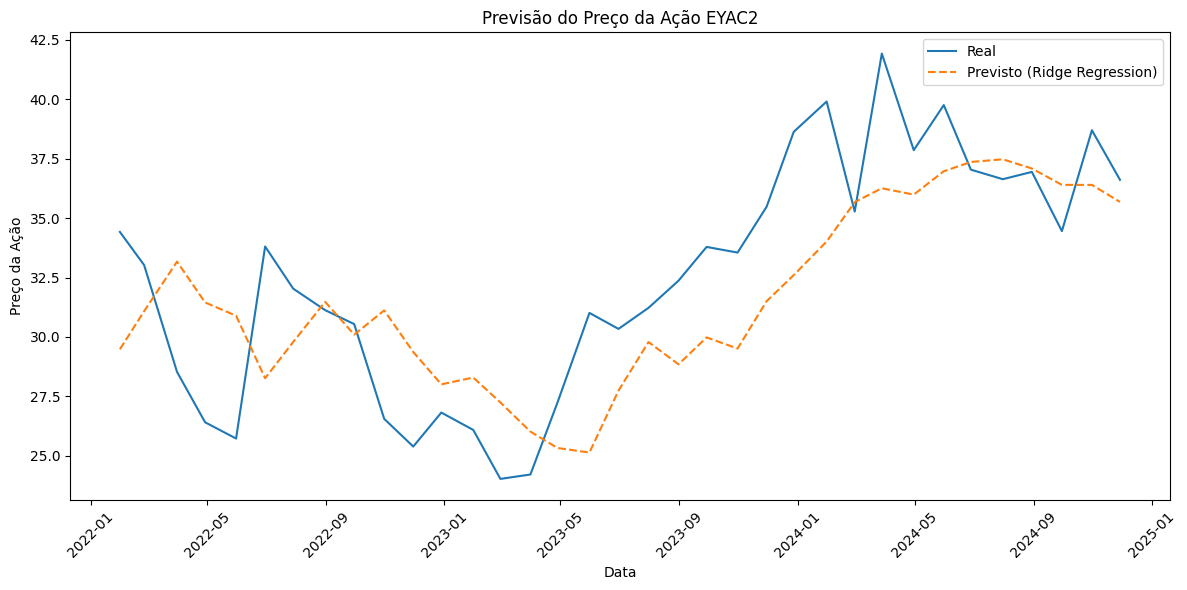

In [33]:
# Plotando as previsões vs reais
plt.figure(figsize=(12,6))
plt.plot(test['Date'], y_test, label='Real')
plt.plot(test['Date'], y_pred_ridge, label='Previsto (Ridge Regression)', linestyle='--')  # Previsões do RandomForest
plt.legend()
plt.title("Previsão do Preço da Ação EYAC2")
plt.xlabel('Data')
plt.ylabel('Preço da Ação')
plt.xticks(rotation=45)  # Para facilitar a leitura das datas
plt.tight_layout()  # Ajustar para que os elementos não se sobreponham
plt.show()


## Erros

In [34]:
# Erro de treinamento
y_train_pred = model.predict(X_train)  # Previsões no conjunto de treino
train_error = mean_squared_error(y_train, y_train_pred)

print(f"Erro no treinamento: {train_error}")
print(f"Erro no teste: {13.31}")


Erro no treinamento: 3.264093937211936
Erro no teste: 13.31


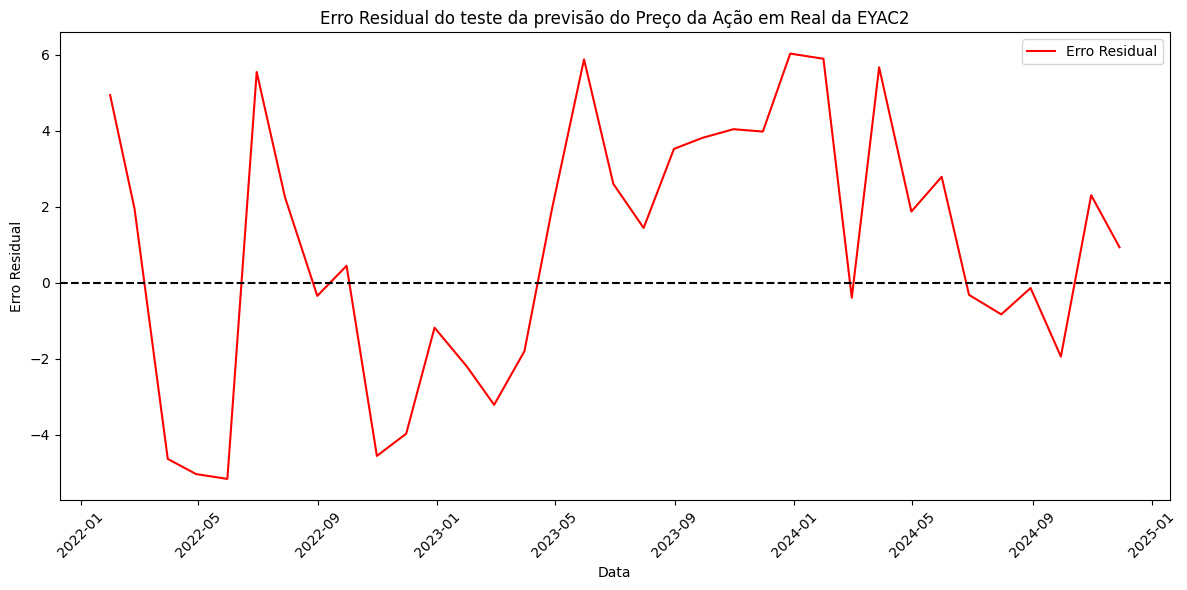

In [35]:
residuals = y_test - y_pred_ridge

# Plotando os resíduos
plt.figure(figsize=(12,6))
plt.plot(test['Date'], residuals, label='Erro Residual', color='red')
plt.axhline(0, color='black', linestyle='--')  # Linha horizontal em y=0
plt.legend()
plt.title("Erro Residual do teste da previsão do Preço da Ação em Real da EYAC2")
plt.xlabel('Data')
plt.ylabel('Erro Residual')
plt.xticks(rotation=45)  # Para facilitar a leitura das datas
plt.tight_layout()  # Ajuste para que os elementos não se sobreponham
plt.show()


# Previsões 2022 - 2024

## Preparação dos dados

In [36]:
df_preds = pd.read_csv("../../camada_ouro/Join_dataframes_new_end.csv", parse_dates=["Date"])
df_preds['Date'] = pd.to_datetime(df_preds['Date'])
df_preds = df_preds.sort_values('Date')

In [37]:
# Limpeza de colunas com %
df_preds['Value_IPCA'] = df_preds['Value_IPCA'].str.replace('%', '').astype(float) / 100
display(df_preds)

,Date,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Índice_Ibovespa,Year-Month,Value_IPCA,Inflac_IPCA,IPCA_Acumulado
0,2010-01-29,33.935703,16106857.97,18.284323,72.89,335.27,65401.77,2010-1,0.0075,0.75,4.312028
1,2010-02-26,31.895180,17804380.32,17.368318,79.66,319.04,66503.27,2010-2,0.0078,0.78,4.592325
2,2010-03-31,37.114391,16551869.40,20.546054,83.76,371.96,70371.54,2010-3,0.0052,0.52,4.831572
3,2010-04-30,30.474053,15688008.79,17.322677,86.15,392.14,67529.73,2010-4,0.0057,0.57,5.166363
4,2010-05-28,29.272740,20301487.26,15.804308,73.97,420.67,61946.99,2010-5,0.0043,0.43,5.260561
...,...,...,...,...,...,...,...,...,...,...,...
175,2024-08-30,36.640116,84437156.59,7.343150,72.65,210.33,136004.01,2024-8,-0.0002,-0.02,4.498245
176,2024-09-30,36.946330,21146409.59,7.156535,67.77,189.29,131816.44,2024-9,0.0044,0.44,4.237599
177,2024-10-31,34.453725,25596765.78,6.663648,68.81,109.20,129713.33,2024-10,0.0056,0.56,4.424740
178,2024-11-29,38.699903,44011586.42,7.111861,67.72,106.39,125667.83,2024-11,0.0039,0.39,4.758099


## Alvo

In [38]:
df_preds['target'] = None 

## Feature Engineering 

### Retorno percentual diário

In [39]:
df_preds['retorno_acao'] = df_preds['Close_Real_EYAC2'].pct_change()
df_preds['retorno_petro'] = df_preds['Price_Dolar_Petro'].pct_change()

df_preds.tail()


,Date,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Índice_Ibovespa,Year-Month,Value_IPCA,Inflac_IPCA,IPCA_Acumulado,target,retorno_acao,retorno_petro
175,2024-08-30,36.640116,84437156.59,7.343150,72.65,210.33,136004.01,2024-8,-0.0002,-0.02,4.498245,None,-0.010822,-0.054529
176,2024-09-30,36.946330,21146409.59,7.156535,67.77,189.29,131816.44,2024-9,0.0044,0.44,4.237599,None,0.008357,-0.067171
177,2024-10-31,34.453725,25596765.78,6.663648,68.81,109.20,129713.33,2024-10,0.0056,0.56,4.424740,None,-0.067466,0.015346
178,2024-11-29,38.699903,44011586.42,7.111861,67.72,106.39,125667.83,2024-11,0.0039,0.39,4.758099,None,0.123243,-0.015841
179,2024-12-30,36.614223,22355586.67,6.605965,70.53,93.10,120283.40,2024-12,0.0052,0.52,4.873011,None,-0.053894,0.041494


### Médias móveis

In [40]:
df_preds['mm7_acao'] = df_preds['Close_Real_EYAC2'].rolling(7).mean()

df_preds.tail()

,Date,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Índice_Ibovespa,Year-Month,Value_IPCA,Inflac_IPCA,IPCA_Acumulado,target,retorno_acao,retorno_petro,mm7_acao
175,2024-08-30,36.640116,84437156.59,7.343150,72.65,210.33,136004.01,2024-8,-0.0002,-0.02,4.498245,None,-0.010822,-0.054529,38.345094
176,2024-09-30,36.946330,21146409.59,7.156535,67.77,189.29,131816.44,2024-9,0.0044,0.44,4.237599,None,0.008357,-0.067171,37.921896
177,2024-10-31,34.453725,25596765.78,6.663648,68.81,109.20,129713.33,2024-10,0.0056,0.56,4.424740,None,-0.067466,0.015346,37.804163
178,2024-11-29,38.699903,44011586.42,7.111861,67.72,106.39,125667.83,2024-11,0.0039,0.39,4.758099,None,0.123243,-0.015841,37.343262
179,2024-12-30,36.614223,22355586.67,6.605965,70.53,93.10,120283.40,2024-12,0.0052,0.52,4.873011,None,-0.053894,0.041494,37.164952


### Volatilidade

In [41]:
df_preds['vol_7_acao'] = df_preds['Close_Real_EYAC2'].rolling(7).std()
df_preds['vol_30_acao'] = df_preds['Close_Real_EYAC2'].rolling(30).std()


df_preds.tail()

,Date,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Índice_Ibovespa,Year-Month,Value_IPCA,Inflac_IPCA,IPCA_Acumulado,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao
175,2024-08-30,36.640116,84437156.59,7.343150,72.65,210.33,136004.01,2024-8,-0.0002,-0.02,4.498245,None,-0.010822,-0.054529,38.345094,2.291950,5.089275
176,2024-09-30,36.946330,21146409.59,7.156535,67.77,189.29,131816.44,2024-9,0.0044,0.44,4.237599,None,0.008357,-0.067171,37.921896,2.227711,5.169478
177,2024-10-31,34.453725,25596765.78,6.663648,68.81,109.20,129713.33,2024-10,0.0056,0.56,4.424740,None,-0.067466,0.015346,37.804163,2.405426,5.145054
178,2024-11-29,38.699903,44011586.42,7.111861,67.72,106.39,125667.83,2024-11,0.0039,0.39,4.758099,None,0.123243,-0.015841,37.343262,1.685257,5.156868
179,2024-12-30,36.614223,22355586.67,6.605965,70.53,93.10,120283.40,2024-12,0.0052,0.52,4.873011,None,-0.053894,0.041494,37.164952,1.687206,5.036931


### Defasagens

In [42]:
df_preds['lag1_acao'] = df_preds['Close_Real_EYAC2'].shift(1)
df_preds['lag60_acao'] = df_preds['Close_Real_EYAC2'].shift(60)


df_preds.tail()

,Date,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Índice_Ibovespa,Year-Month,Value_IPCA,Inflac_IPCA,IPCA_Acumulado,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
175,2024-08-30,36.640116,84437156.59,7.343150,72.65,210.33,136004.01,2024-8,-0.0002,-0.02,4.498245,None,-0.010822,-0.054529,38.345094,2.291950,5.089275,37.040958,24.936869
176,2024-09-30,36.946330,21146409.59,7.156535,67.77,189.29,131816.44,2024-9,0.0044,0.44,4.237599,None,0.008357,-0.067171,37.921896,2.227711,5.169478,36.640116,25.236485
177,2024-10-31,34.453725,25596765.78,6.663648,68.81,109.20,129713.33,2024-10,0.0056,0.56,4.424740,None,-0.067466,0.015346,37.804163,2.405426,5.145054,36.946330,31.298800
178,2024-11-29,38.699903,44011586.42,7.111861,67.72,106.39,125667.83,2024-11,0.0039,0.39,4.758099,None,0.123243,-0.015841,37.343262,1.685257,5.156868,34.453725,26.719566
179,2024-12-30,36.614223,22355586.67,6.605965,70.53,93.10,120283.40,2024-12,0.0052,0.52,4.873011,None,-0.053894,0.041494,37.164952,1.687206,5.036931,38.699903,30.690218


In [43]:
df_test = df_preds[['Date','target','retorno_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao','lag1_acao', 'lag60_acao']]
display(df_test)

,Date,target,retorno_acao,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
0,2010-01-29,None,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-02-26,None,-0.060129,NaN,NaN,NaN,33.935703,NaN
2,2010-03-31,None,0.163636,NaN,NaN,NaN,31.895180,NaN
3,2010-04-30,None,-0.178915,NaN,NaN,NaN,37.114391,NaN
4,2010-05-28,None,-0.039421,NaN,NaN,NaN,30.474053,NaN
...,...,...,...,...,...,...,...,...
175,2024-08-30,None,-0.010822,38.345094,2.291950,5.089275,37.040958,24.936869
176,2024-09-30,None,0.008357,37.921896,2.227711,5.169478,36.640116,25.236485
177,2024-10-31,None,-0.067466,37.804163,2.405426,5.145054,36.946330,31.298800
178,2024-11-29,None,0.123243,37.343262,1.685257,5.156868,34.453725,26.719566


## Tratamento de Dados

In [44]:
# Preencher valores NaN para variáveis de lag usando dados históricos (não usar dados futuros)
df_preds.loc[:, ['lag1_acao']] = df_preds[['lag1_acao']].bfill(limit=1)

# Para lag60_acao, dado o grande deslocamento de 60 dias, podemos usar a média histórica para preencher os NaN restantes
df_preds.loc[:, ['lag60_acao']] = df_preds[['lag60_acao']].fillna(df_preds['lag60_acao'].mean())

# Preencher as NaN nas outras variáveis com a média histórica (sem usar dados futuros)
df_preds.loc[:, ['retorno_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 'Price_Dolar_Petro', 'Índice_Ibovespa', 'retorno_petro']] = \
df_preds[['retorno_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 'Price_Dolar_Petro', 'Índice_Ibovespa', 'retorno_petro']].fillna(
    df_preds[['retorno_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 'Price_Dolar_Petro', 'Índice_Ibovespa', 'retorno_petro']].mean())

# Verifique se ainda há valores NaN após o preenchimento
print(df_preds.isna().sum())


Date                   0
Close_Real_EYAC2       0
Volume_EYAC2           0
Close_Dolar_EYAC2      0
Price_Dolar_Petro      0
Volume_Petro           0
Índice_Ibovespa        0
Year-Month             0
Value_IPCA             0
Inflac_IPCA            0
IPCA_Acumulado         0
target               180
retorno_acao           0
retorno_petro          0
mm7_acao               0
vol_7_acao             0
vol_30_acao            0
lag1_acao              0
lag60_acao             0
dtype: int64


In [45]:
df_test1 = df_preds[['Date','target','retorno_acao','mm7_acao', 'vol_7_acao', 'vol_30_acao', 'lag1_acao','lag60_acao']]
display(df_test1)

df_test1.to_csv('test1.csv', index = False)

,Date,target,retorno_acao,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
0,2010-01-29,None,0.016191,22.010240,2.662170,4.032121,33.935703,19.128547
1,2010-02-26,None,-0.060129,22.010240,2.662170,4.032121,33.935703,19.128547
2,2010-03-31,None,0.163636,22.010240,2.662170,4.032121,31.895180,19.128547
3,2010-04-30,None,-0.178915,22.010240,2.662170,4.032121,37.114391,19.128547
4,2010-05-28,None,-0.039421,22.010240,2.662170,4.032121,30.474053,19.128547
...,...,...,...,...,...,...,...,...
175,2024-08-30,None,-0.010822,38.345094,2.291950,5.089275,37.040958,24.936869
176,2024-09-30,None,0.008357,37.921896,2.227711,5.169478,36.640116,25.236485
177,2024-10-31,None,-0.067466,37.804163,2.405426,5.145054,36.946330,31.298800
178,2024-11-29,None,0.123243,37.343262,1.685257,5.156868,34.453725,26.719566


In [46]:
df_preds.isna().sum()

Date                   0
Close_Real_EYAC2       0
Volume_EYAC2           0
Close_Dolar_EYAC2      0
Price_Dolar_Petro      0
Volume_Petro           0
Índice_Ibovespa        0
Year-Month             0
Value_IPCA             0
Inflac_IPCA            0
IPCA_Acumulado         0
target               180
retorno_acao           0
retorno_petro          0
mm7_acao               0
vol_7_acao             0
vol_30_acao            0
lag1_acao              0
lag60_acao             0
dtype: int64

## Definindo Features e Target

In [47]:
# Exemplo de ajuste para evitar data leakage
feature_names1 = ['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 'Price_Dolar_Petro', 'Índice_Ibovespa', 'retorno_acao', 'retorno_petro']

# Filtragem de dados para o período de previsão (2022-2024)
test_data = df_preds[df_preds['Date'] >= '2022-01-01']

# Para 2022-2024, as variáveis de lag devem ser baseadas apenas nos dados de 2021 ou anteriores
test_data['lag1_acao'] = df_preds['lag1_acao'].iloc[-1]  # Usar o último valor de 2021 para 2022
test_data['lag60_acao'] = df_preds['lag60_acao'].iloc[-1]  # Usar o último valor de 2021 para 2022

# Preencher NaN nas outras variáveis com a média histórica (sem usar dados futuros)
test_data.loc[:, ['retorno_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 'Price_Dolar_Petro', 'Índice_Ibovespa', 'retorno_petro']] = \
test_data[['retorno_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 'Price_Dolar_Petro', 'Índice_Ibovespa', 'retorno_petro']].fillna(
    test_data[['retorno_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 'Price_Dolar_Petro', 'Índice_Ibovespa', 'retorno_petro']].mean())

# Verificar se ainda há NaN nas features após o preenchimento
print(test_data.isna().sum())

# Selecionar as features para previsão
X_test = test_data[feature_names1]

# Escalonamento das features com base no scaler treinado nos dados de 2010-2021 (sem recalcular o fit)
X_test_scaled = scaler.transform(X_test)

Date                  0
Close_Real_EYAC2      0
Volume_EYAC2          0
Close_Dolar_EYAC2     0
Price_Dolar_Petro     0
Volume_Petro          0
Índice_Ibovespa       0
Year-Month            0
Value_IPCA            0
Inflac_IPCA           0
IPCA_Acumulado        0
target               36
retorno_acao          0
retorno_petro         0
mm7_acao              0
vol_7_acao            0
vol_30_acao           0
lag1_acao             0
lag60_acao            0
dtype: int64


C:\Users\FM972EJ\AppData\Local\Temp\ipykernel_27728\688242188.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['lag1_acao'] = df_preds['lag1_acao'].iloc[-1]  # Usar o último valor de 2021 para 2022
C:\Users\FM972EJ\AppData\Local\Temp\ipykernel_27728\688242188.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['lag60_acao'] = df_preds['lag60_acao'].iloc[-1]  # Usar o último valor de 2021 para 2022


In [48]:
test_data.to_csv('test2.csv', index = False)

## Previsão

In [49]:
# Fazer previsões para os valores de target ausentes
y_pred = ridge_model.predict(X_test_scaled)

# Preencher o target de 2022 a 2024 com as previsões feitas
df_preds.loc[df_preds['Date'] >= '2022-01-01', 'target'] = y_pred

# Exibir as previsões para o período de 2022-2024
future_preds = []

# Selecionar os dados de 2022 a 2024 para previsão
predict_data = df_preds[(df_preds['Date'] >= '2022-01-01') & (df_preds['Date'] <= '2024-12-31')]

# Armazenar as previsões e atualizar no DataFrame
for idx, predicted_target in zip(predict_data.index, y_pred):
    df_preds.at[idx, 'target'] = predicted_target
    future_preds.append((df_preds.at[idx, 'Date'], predicted_target))

# Exibir as previsões
future_preds_df = pd.DataFrame(future_preds, columns=['Date', 'Predicted_Target'])
display(future_preds_df)

,Date,Predicted_Target
0,2022-01-31,33.206970
1,2022-02-25,33.572450
2,2022-03-31,34.460769
3,2022-04-29,33.181364
4,2022-05-31,34.066385
5,2022-06-30,32.094701
6,2022-07-29,33.855359
7,2022-08-31,32.943312
8,2022-09-30,32.135162
9,2022-10-31,33.481257


In [50]:
df_preds.isna().sum()

Date                   0
Close_Real_EYAC2       0
Volume_EYAC2           0
Close_Dolar_EYAC2      0
Price_Dolar_Petro      0
Volume_Petro           0
Índice_Ibovespa        0
Year-Month             0
Value_IPCA             0
Inflac_IPCA            0
IPCA_Acumulado         0
target               144
retorno_acao           0
retorno_petro          0
mm7_acao               0
vol_7_acao             0
vol_30_acao            0
lag1_acao              0
lag60_acao             0
dtype: int64

## Comparação entre o Real e o Preditivo

In [51]:
# Comparar as previsões feitas com os valores reais
real_data_model = df_model[(df_model['Date'] >= '2022-01-01') & (df_model['Date'] <= '2024-12-31')]
pred_data_preds = df_preds[(df_preds['Date'] >= '2022-01-01') & (df_preds['Date'] <= '2024-12-31')]

# Realizar o merge para comparar 'target' (real) e 'predicted_target' (previsto)
comparison_df = pd.merge(real_data_model[['Date', 'target']], pred_data_preds[['Date', 'target']], on='Date', how='left', suffixes=('_Real', '_Predicted'))

# Exibir a comparação
display(comparison_df)

,Date,target_Real,target_Predicted
0,2022-01-31,34.421277,33.20697
1,2022-02-25,33.025554,33.57245
2,2022-03-31,28.527867,34.460769
3,2022-04-29,26.408882,33.181364
4,2022-05-31,25.724300,34.066385
5,2022-06-30,33.807136,32.094701
6,2022-07-29,32.033401,33.855359
7,2022-08-31,31.128364,32.943312
8,2022-09-30,30.541552,32.135162
9,2022-10-31,26.553445,33.481257


## Visualização da previsão

Tamanho de test_filtered['Date']:  35
Tamanho de y_pred_ridge_filtered:  35


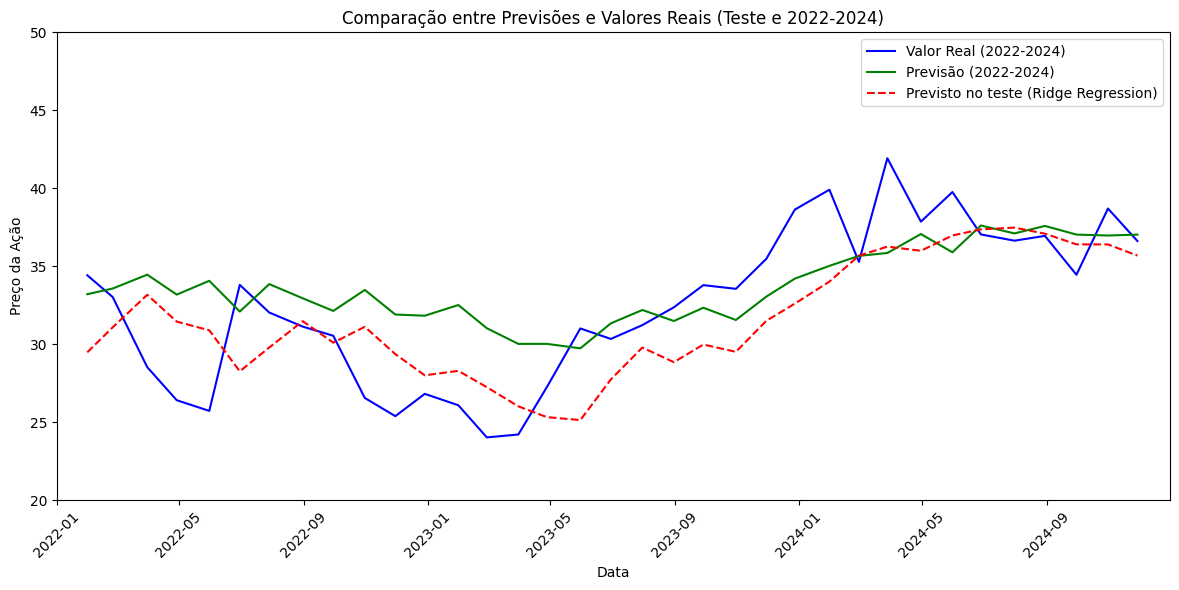

In [60]:
# Defina o intervalo de tempo desejado para a visualização
start_date = '2022-01-01'  # Data de início
end_date = '2024-12-31'    # Data de término

comparison_df_filtered = comparison_df[(comparison_df['Date'] >= start_date) & (comparison_df['Date'] <= end_date)]

# Filtrar tanto as datas de teste quanto as previsões pelo mesmo intervalo
test_filtered = test[(test['Date'] >= start_date) & (test['Date'] <= end_date)]

# Ajuste y_pred_ridge para ter as previsões correspondentes a test_filtered
y_pred_ridge_filtered = y_pred_ridge[:len(test_filtered)]  # Garantir que as previsões correspondam ao número de amostras em test_filtered

# Verificar os tamanhos após a filtragem
print("Tamanho de test_filtered['Date']: ", len(test_filtered['Date']))
print("Tamanho de y_pred_ridge_filtered: ", len(y_pred_ridge_filtered))

# Verifique se as datas e previsões têm o mesmo tamanho
if len(test_filtered['Date']) == len(y_pred_ridge_filtered):
    plt.figure(figsize=(12, 6))

    # Plotando os valores reais de 2022 a 2024 (com base no comparison_df)
    plt.plot(comparison_df_filtered['Date'], comparison_df_filtered['target_Real'], label='Valor Real (2022-2024)', color='blue')
    plt.plot(comparison_df_filtered['Date'], comparison_df_filtered['target_Predicted'], label='Previsão (2022-2024)', color='green')

    # Plotando as previsões feitas pelo modelo para o teste (Ridge Regression ou outro)
    plt.plot(test_filtered['Date'], y_pred_ridge_filtered, label='Previsto no teste (Ridge Regression)', linestyle='--', color='red')

    # Adicionando título e rótulos
    plt.legend()
    plt.title('Comparação entre Previsões e Valores Reais (Teste e 2022-2024)')
    plt.xlabel('Data')
    plt.ylabel('Preço da Ação')

    plt.ylim(20, 50)

    # Ajustando a exibição das datas
    plt.xticks(rotation=45)

    # Ajuste para que os elementos não se sobreponham
    plt.tight_layout()

    # Ajustando o intervalo de tempo no eixo x
    plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

    # Mostrar o gráfico
    plt.show()

else:
    print("Erro: As dimensões de 'test_filtered['Date']' e 'y_pred_ridge' não coincidem!")

## Erros

In [53]:
# Calcular o erro percentual total (erro percentual global)
total_error_percentage = (abs(comparison_df['target_Real'] - comparison_df['target_Predicted']).sum() / abs(comparison_df['target_Real']).sum()) * 100

# Exibir o erro percentual total
print(f'Erro Percentual Total: {total_error_percentage:.2f}%')


Erro Percentual Total: 9.41%


In [54]:
# Calculando o erro percentual absoluto (percentual de erro)
comparison_df['percentual_erro'] = (abs(comparison_df['target_Real'] - comparison_df['target_Predicted']) / abs(comparison_df['target_Real'])) * 100

# Calcular o erro percentual médio (MAPE)
mape = comparison_df['percentual_erro'].mean()
print(f'Média do Erro Percentual Absoluto (MAPE): {mape:.2f}%')


Média do Erro Percentual Absoluto (MAPE): 10.38%


In [55]:
# Exibindo os erros percentuais para cada previsão
display(comparison_df[['Date', 'target_Real', 'target_Predicted', 'percentual_erro']])

# Salvando os erros percentuais em um arquivo CSV
comparison_df[['Date', 'target_Real', 'target_Predicted', 'percentual_erro']].to_csv('../../camada_ouro/comparison_real_vs_preds_vs_erros_Real.csv', index=False)


,Date,target_Real,target_Predicted,percentual_erro
0,2022-01-31,34.421277,33.20697,3.52778
1,2022-02-25,33.025554,33.57245,1.655976
2,2022-03-31,28.527867,34.460769,20.796865
3,2022-04-29,26.408882,33.181364,25.644713
4,2022-05-31,25.724300,34.066385,32.428815
5,2022-06-30,33.807136,32.094701,5.065306
6,2022-07-29,32.033401,33.855359,5.687683
7,2022-08-31,31.128364,32.943312,5.83053
8,2022-09-30,30.541552,32.135162,5.21784
9,2022-10-31,26.553445,33.481257,26.090071


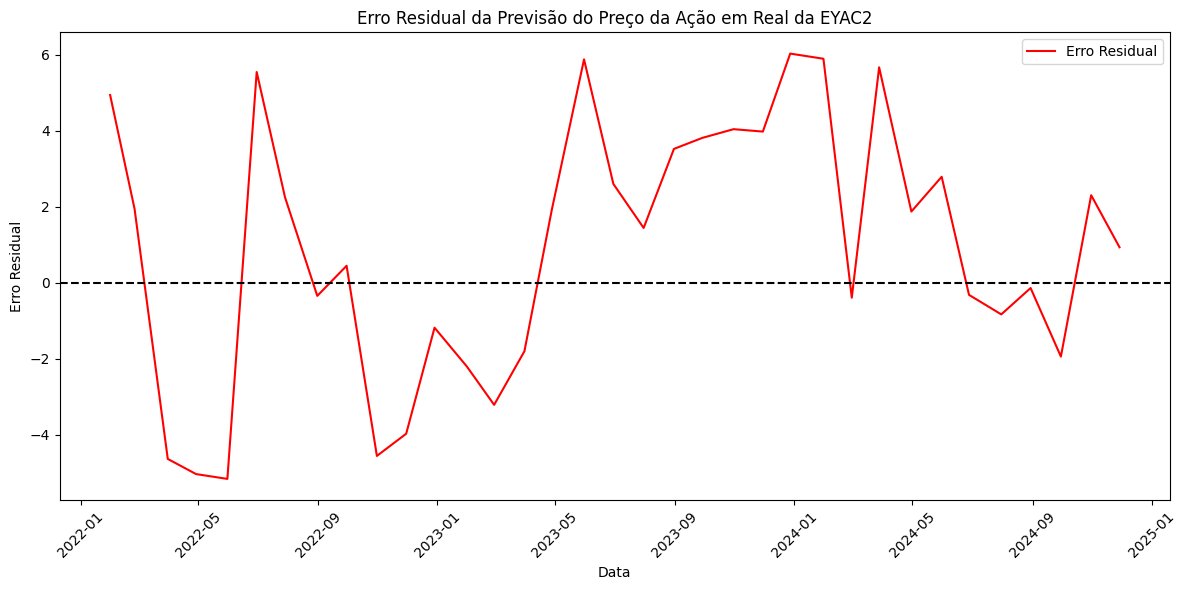

In [56]:
# Calculando os resíduos
residuals = y_test - y_pred_ridge_filtered


# Plotando os resíduos
plt.figure(figsize=(12,6))
plt.plot(test['Date'], residuals, label='Erro Residual', color='red')
plt.axhline(0, color='black', linestyle='--')  # Linha horizontal em y=0
plt.legend()
plt.title("Erro Residual da Previsão do Preço da Ação em Real da EYAC2")
plt.xlabel('Data')
plt.ylabel('Erro Residual')
plt.xticks(rotation=45)  # Para facilitar a leitura das datas
plt.tight_layout()  # Ajuste para que os elementos não se sobreponham
plt.show()
